---
# Strategie zero-kosztowe - Kryzys opcji walutowych w Polsce w 2008 roku

In [1]:
import numpy as np
from scipy.stats import norm
from scipy import optimize          
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import if2 as if2
import date_operations as dop 

---
### Historyczne (2007-2008) wartości kursów walutowych NBP

In [2]:
FixingNBP_2007    = pd.read_excel('NBP_FXrates_2007.xlsx','Sheet1', index_col=0, parse_dates=True)
FixingNBP_2008    = pd.read_excel('NBP_FXrates_2008.xlsx','Sheet1', index_col=0, parse_dates=True)
FixingNBP_2009    = pd.read_excel('NBP_FXrates_2009.xlsx','Sheet1', index_col=0, parse_dates=True)
FixingNBP_2007_09 = pd.concat([FixingNBP_2007,FixingNBP_2008,FixingNBP_2009])
EURPLN_2007_09    = FixingNBP_2007_09["1 EUR"]

---
### Mimimum kursu EUR/PLN w okresie 2007-2009

In [3]:
EURPLN_min = EURPLN_2007_09.min()
Index_min  = int(np.where(EURPLN_2007_09==EURPLN_min)[0])
Data_min   = EURPLN_2007_09.index[Index_min].date()
print("Minimum kursu EUR/PLN")
print(f"Indeks: {Index_min}")
print(f"Data:   {Data_min}")
print(f"Kurs:   {EURPLN_min}")
type(Data_min)

Minimum kursu EUR/PLN
Indeks: 401
Data:   2008-07-31
Kurs:   3.2026


datetime.date

---
### Malejący trend kursu EUR/PLN od 2007 do 1 sierpnia 2008

<Figure size 1600x900 with 0 Axes>

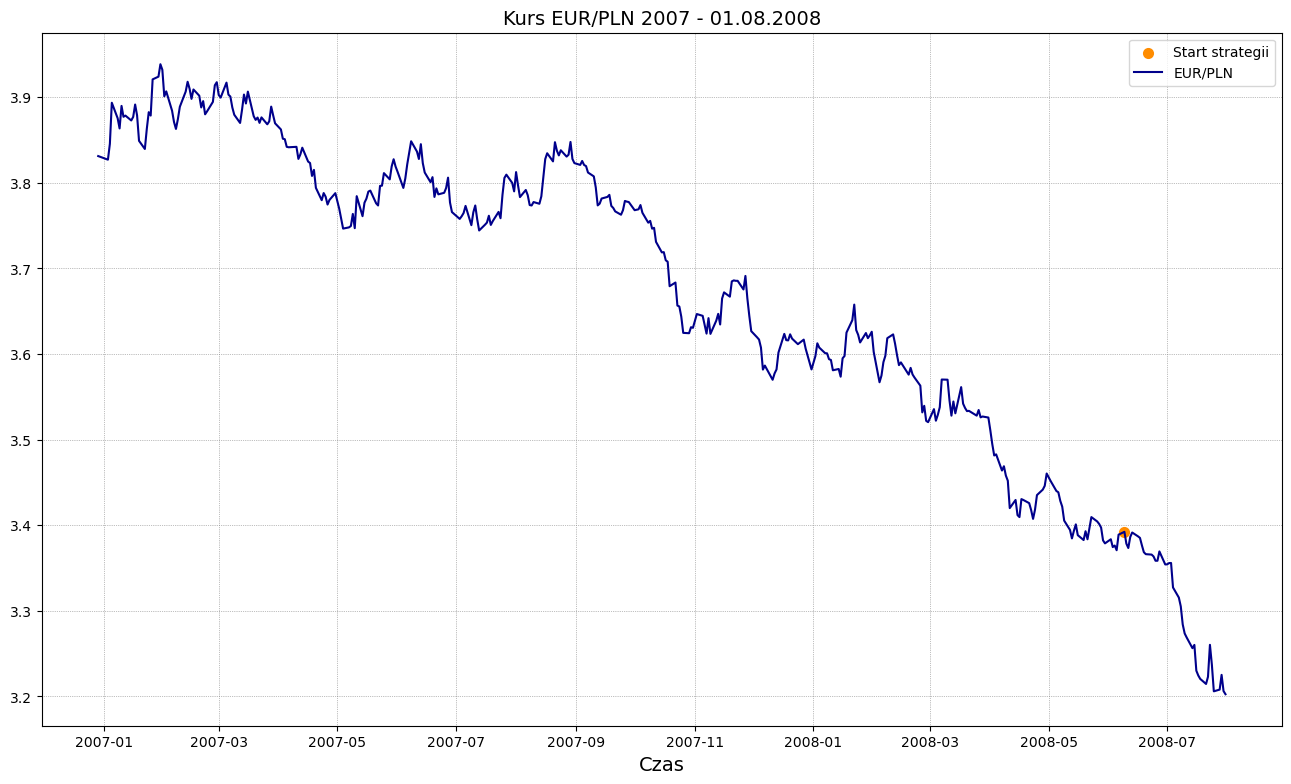

In [4]:
Start_date = datetime.strptime("2008-06-09", '%Y-%m-%d') # W tym momencie eksporter zawiera transakcję zabezpieczającą
plt.figure(figsize=(16,9))
fig, axl=plt.subplots(figsize=(16,9))
axl.set_title("Kurs EUR/PLN 2007 - 01.08.2008",fontsize=14)
axl.set_xlabel("Czas",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
axl.plot(EURPLN_2007_09.loc[:Data_min],color='darkblue',label="EUR/PLN")
axl.scatter(Start_date,EURPLN_2007_09.loc[Start_date],color='darkorange',linewidth=2.0,label="Start strategii")
axl.legend(loc='upper right', reverse=True)
plt.show()

---
### Tworzymy strategię zerokosztową - kupiony put oraz sprzedany call

In [9]:
Start_date = datetime.strptime("2008-06-09", '%Y-%m-%d') # Data zawiązania strategii
Mat_date   = datetime.strptime("2009-06-09", '%Y-%m-%d') # Data wygaśnięcia strategii \ Strategia 1Y
FXspot     = EURPLN_2007_09.loc[Start_date]              # Kurs z daty zawiązania strategii
r_f = 0.05
r_d = 0.10
sig = 0.15
T = dop.yf(Start_date,Mat_date,"ACT/365")  # Strategia roczna
N_p = 1
K_p = 3.30
N_c = 2.0*N_p                             # Jeśli N_c > N_p klient ryzykuje kwotą N_c-N_p, bo zakładamy ze N_p będzie miał
#K_c = 4.00

def ZC_strategy(FXspot,sig,r_d,r_f,T,K_p,N_p,K_c,N_c): #wartość od strony posiadacza opcji Put / klienta
    if T>0:
        df_f = np.exp(-r_f*T)
        df_d = np.exp(-r_d*T)
        V_p = if2.ValueBS(-1, FXspot, sig, df_d, df_f, K_p, T, N_p)
        V_c = if2.ValueBS(+1, FXspot, sig, df_d, df_f, K_c, T, N_c)
        Value = V_p-V_c  
    elif T==0:
        Value = N_p*if2.VanillaPay(-1,FXspot,K_p)-N_c*if2.VanillaPay(1,FXspot,K_c)
    else: Value = 0.0
    return Value

# Szukanie ceny wykonania opcji call $K_c$, przy którym początkowa wartość strategii wynosi 0.

f_zcs = lambda K: ZC_strategy(FXspot,sig,r_d,r_f,T,K_p,N_p,K,N_c)
K_c = optimize.newton(f_zcs,4.00)

# Sprawdzenie czy przy znalezionym K_c strategia ma na początku wartość 0.
V_ZCS=ZC_strategy(FXspot,sig,r_d,r_f,T,K_p,N_p,K_c,N_c)

print(f"Data zawarcia strategii:         {Start_date.date()}")
print(f"Kurs w dacie zawarcia strategii: {FXspot}")
print(f"Opcja put -----------------------------------")
print(f"Cena wykonania opcji put:       {K_p: 6.4f} EUR/PLN")
print(f"Nominał opcji put:             {N_p: 6.2f} mEUR")
print(f"Opcja call ----------------------------------")
print(f"Cena wykonania opcji call:      {K_c: 6.4f} EUR/PLN")
print(f"Nominał opcji call:            {N_c: 6.2f} mEUR")
print(f"---------------------------------------------")
print(f"Wartość strategii:              {V_ZCS :6.4f} PLN")

Data zawarcia strategii:         2008-06-09
Kurs w dacie zawarcia strategii: 3.3923
Opcja put -----------------------------------
Cena wykonania opcji put:        3.3000 EUR/PLN
Nominał opcji put:               1.00 mEUR
Opcja call ----------------------------------
Cena wykonania opcji call:       4.1328 EUR/PLN
Nominał opcji call:              2.00 mEUR
---------------------------------------------
Wartość strategii:              0.0000 PLN


---
### Trendy nie trwają wiecznie.  
### Od 1 sierpnia 2008 kurs EUR/PLN zaczął gwałtowanie rosnąć.

<Figure size 1600x900 with 0 Axes>

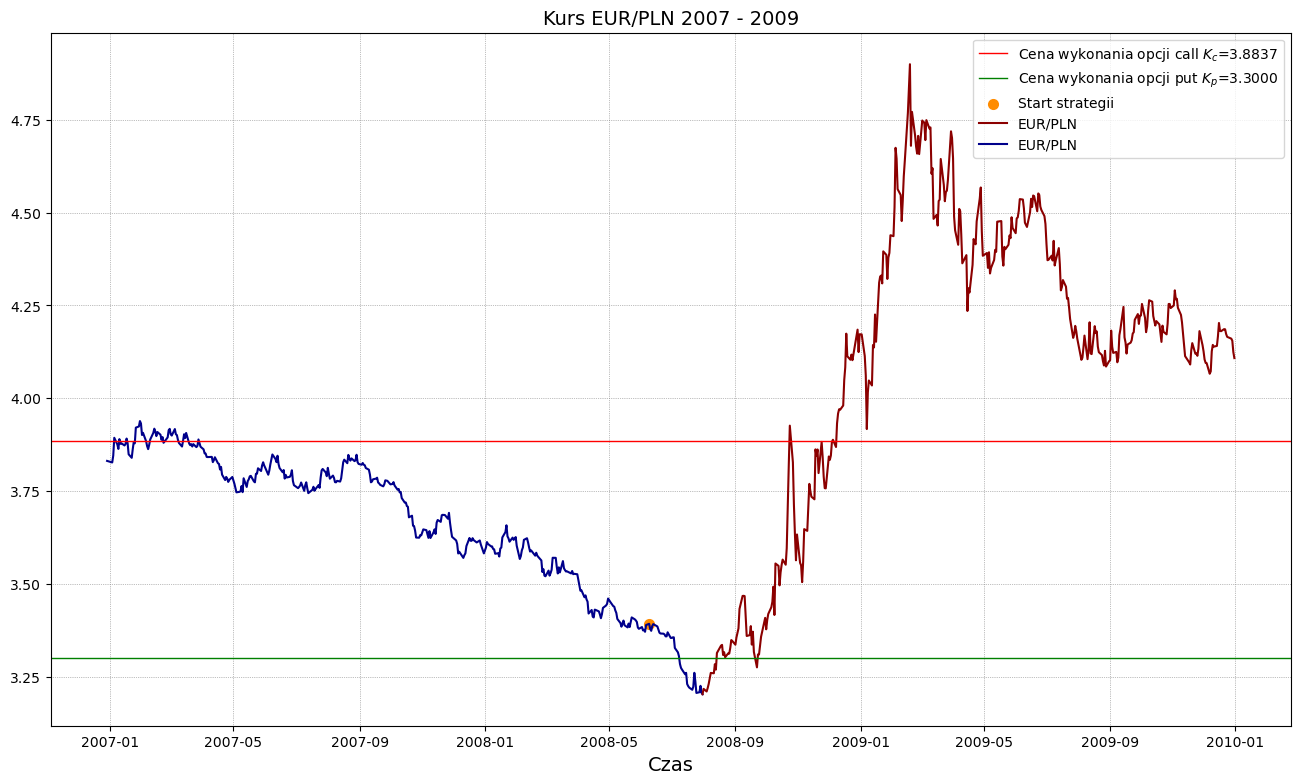

In [6]:
plt.figure(figsize=(16,9))
fig, axl=plt.subplots(figsize=(16,9))
axl.set_title("Kurs EUR/PLN 2007 - 2009",fontsize=14)
axl.set_xlabel("Czas",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
axl.plot(EURPLN_2007_09.loc[:Data_min],color='darkblue',label="EUR/PLN")
axl.plot(EURPLN_2007_09.loc[Data_min:],color='darkred',label="EUR/PLN")
axl.scatter(Start_date,EURPLN_2007_09.loc[Start_date],color='darkorange',linewidth=2.0,label="Start strategii")
axl.axhline(K_p,color='green',linewidth=1.0,label=f"Cena wykonania opcji put $K_p$={K_p:6.4f}")
axl.axhline(K_c,color='red',linewidth=1.0,label=f"Cena wykonania opcji call $K_c$={K_c:6.4f}")
axl.legend(loc='upper right', reverse=True)
plt.show()


---
### Wybór danych do wyliczania wartości strategii w trakcie jej trwania az do wygaśnięcia

In [7]:
FXrange = EURPLN_2007_09.loc[Start_date:Mat_date]
Dates   = EURPLN_2007_09.loc[Start_date:Mat_date].index
FXrange_down =  EURPLN_2007_09.loc[Start_date:Data_min]
Dates_down =  EURPLN_2007_09.loc[Start_date:Data_min].index
T_res   = (Mat_date-Dates).days/365.0

---
### Wykres wartości stratregii w trakcie jej trwania

<Figure size 1600x900 with 0 Axes>

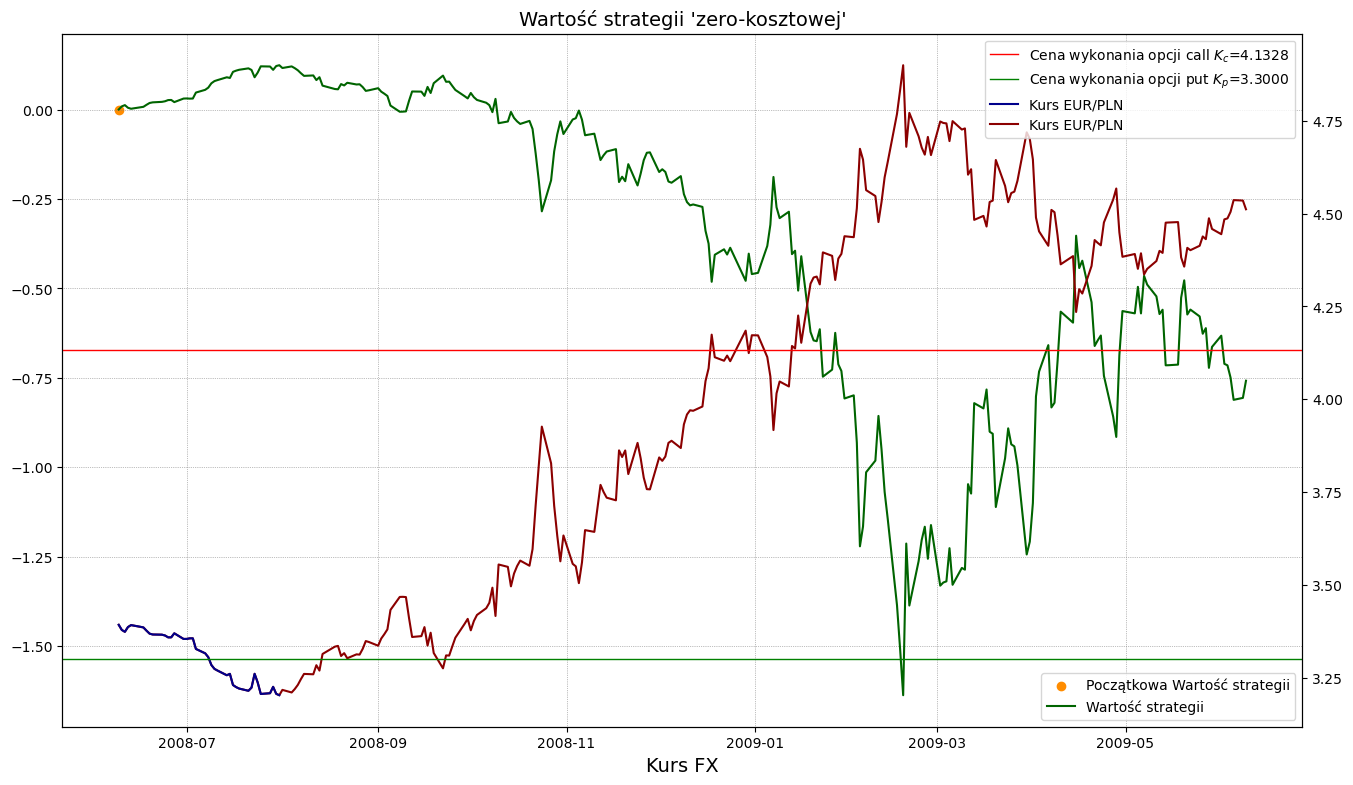

In [10]:
V_ZCS = np.zeros(len(FXrange))

for k in range(len(FXrange)):
    V_ZCS[k]=ZC_strategy(FXrange[k],sig,r_d,r_f,T_res[k],K_p,N_p,K_c,N_c)

plt.figure(figsize=(16,9))
fig, axl=plt.subplots(figsize=(16,9))
axl.set_title("Wartość strategii 'zero-kosztowej'",fontsize=14)
axl.set_xlabel("Kurs FX",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
axl.plot(Dates,V_ZCS,color='darkgreen',label="Wartość strategii")
axl.scatter(Dates[0],V_ZCS[0],color='darkorange',label="Początkowa Wartość strategii")
axl.legend(loc='lower right', reverse=True)

axl2=axl.twinx()
axl2.plot(Dates,FXrange,color="darkred",label="Kurs EUR/PLN")
axl2.plot(Dates_down,FXrange_down,color="darkblue",label="Kurs EUR/PLN")
axl2.axhline(K_p,color='green',linewidth=1.0,label=f"Cena wykonania opcji put $K_p$={K_p:6.4f}")
axl2.axhline(K_c,color='red',linewidth=1.0,label=f"Cena wykonania opcji call $K_c$={K_c:6.4f}")
axl2.legend(loc='upper right', reverse=True)
plt.show()